# Jupyter notebook for LDA classifying
In this notebook both LDA-CCA and LDA-cherry have been implemented a 10-fold cross validation is performed and you can save your classification accuracies as well as the computation times for further statistical analysis in the statistical analysis notebook. For any questions regarding this or any other notebook on this git you can contact me at e.lems@student.ru.nl

## Imports
Here all the needed imports are shown. A list of versions is given as a .txt file in the git.

In [2]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import os
import sklearn as sk
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pyriemann
from scipy.interpolate import griddata
from matplotlib.patches import Circle, Ellipse, Polygon
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cross_decomposition import CCA
from sklearn.covariance import ledoit_wolf
from scipy import stats
import seaborn as sns

import timeit
import math

## Functions
Here I show multiple functions that have been used in this notebook. It could be that there are multiple versions of functions so please look in the main loops which are used.
    - def slice_data(X, V, y, window_size, nr_epochs,step_size) 
    Here the data is sliced according to the window size, number of epochs and step size
    - def reshape_transpose(X,y) is used to reshape and transpose the data
    - def create_prototypes(X, val) is used to create the prototypes used in the MDM classifier
    - covariances_ERP_CCA(X, P_cca) is used to create the co-variance matrices given your data X and the prototype you give
    - covariances_ERP(X, P) is used for the cherry method
    - calibrate_lda(X,y) here the MDM classifier is fit on the data and the computation time is measured
    - predict_epochs(mdm, test) is used to predict epochs
    - The functions get_cca_weights, apply_cca_filter, apply_cca_filter_prototype were used to distinguish these processes however in get_apply_cca_weights these processes are merged
    - get_apply_cca_weights(X,validation, prototype_target,prototype_non_target, prototype, X_test) is used to apply CCA to the data and prototypes here you can also set how many components you want
    - get_indices(num_fold, n_trials, fold_index) and make_placeholder() are used together to establish how much training time you want
    - classify_trials_cross0(predictions_lda, y, t_test, e_test, n_trials, sV) is used to classify on trial level
    - topoplot(z, c="nt_cap8.loc", cbar=False, ax=None) is used to plot the spatial filters. This is in part provided by Jordy Thielen. Small adaptations have been made.

In [2]:
def slice_data(X, V, y, window_size, nr_epochs,step_size):

    sX = [X[:,i*step_size:i*step_size+window_size,:] for i in range(nr_epochs)]
    sV = [V[i*step_size,:] for i in range(nr_epochs)]
    
    sV = np.array(sV)
    sX = np.array(sX)
    sX = np.transpose(sX,(1,2,3,0))
    
    validation = np.zeros((y.shape[0],sV.shape[0]))
    for i in range(y.shape[0]):
        letter_index = y[i,0]-1
        validation[i,:] = sV[:,letter_index] 

    return sX, sV, validation

In [3]:
def reshape_transpose(X,y):
    x_channel, x_window, x_trial, x_epoch = X.shape

    Xtrain = X.reshape(x_channel * x_window, x_trial* x_epoch)
    Xtrain = Xtrain.transpose(1,0)
    ytrain = y.reshape(x_trial * x_epoch)
    
    return Xtrain, ytrain

In [4]:
def create_prototypes(X, val):
    # Dimensions
    #t_val, e_val = val.shape
    c_X, w_X, t_X, e_X = X.shape
    
    # Flatten 
    #val_flat = val.reshape(t_val*e_val)
    X_flat = X.reshape(c_X, w_X, t_X*e_X )
    
    # Take indices where target and non-target
    res_1 = np.where(val==1)
    res_0 = np.where(val==0)

    # Select all data points where target or non-target
    t = X_flat[:,:,res_1[0]]
    non_t = X_flat[:,:,res_0[0]]
    
    # Average over epochs
    prototype_target = np.mean(t,axis=2)
    prototype_non_target = np.mean(non_t,axis=2)
    
    # Concatenate prototypes
    prototypes = np.concatenate((prototype_target,prototype_non_target),axis=0)
    
    return prototypes, prototype_target, prototype_non_target

In [5]:
def covariances_ERP_CCA(X, P_cca):
    # Dimensions
    c, win,epo_trial = X.shape
    n_prototypes = P_cca.shape[0]
        
    # Transposing X
    X = X.transpose((2,0,1))
    
    # Creating the shape of the mega matrix containing all covariance matrices
    cov_matrices = np.zeros((epo_trial, c+ n_prototypes, c+ n_prototypes))
    
    # Filling the matrix by making sample covariance matrices of the prototypes concatenated with X.
    
    for i in range(epo_trial):
        cov_matrices[i, :, :] = np.cov( np.concatenate((P_cca, X[i, :,:]), axis=0))
        
    return cov_matrices

In [7]:
def predict_epochs(mdm, test):
    prediction_probabilities = mdm.predict_proba(test)
    return prediction_probabilities

In [24]:
def classify_trials(predictions_lda, y, t_test, e_test, train_test_size, n_trials, sV):
    proba_predictions = predictions_lda[:,1]
    proba_predictions = proba_predictions.reshape(t_test,e_test)
    predictions = np.zeros(t_test)

    for i in range(t_test):
        rho = np.corrcoef(proba_predictions[i,:],sV.T)[0, 1:]
        predictions[i]=np.argmax(rho)+1

#     print('Predictions: \n',predictions)
    n_correct = sum(predictions == y[train_test_size:n_trials,0])
    acc = np.mean(predictions == y[train_test_size:n_trials,0])


    return acc

In [25]:
def classify_trials_cross(predictions_lda, y, t_test, e_test, n_trials, sV):
    proba_predictions = predictions_lda[:,1]
    proba_predictions = proba_predictions.reshape(t_test,e_test)
    predictions = np.zeros(t_test)
    
    #y = y.reshape(t_test,e_test)

    for i in range(t_test):
        rho = np.corrcoef(proba_predictions[i,:],sV.T)[0, 1:]
        predictions[i]=np.argmax(rho)+1

#     print('Predictions: \n',predictions)
#     print('labels \n',y[:,0])
    n_correct = sum(predictions == y[:,0])
    acc = np.mean(predictions == y[:,0])


    print('Accuracy: {:.2f}%'.format(acc*100))

    return acc

In [26]:
def get_cca_weights(X,validation, prototype_target,prototype_non_target):
    # Get dimensions
    n_channels, window, n_trials, n_epochs = X.shape
    #v_trial, v_epoch = validation.shape
    trial_epoch_cca = n_trials * n_epochs
    
    # Reshape X and validation
    #val_cca = validation.reshape(v_trial * v_epoch)
    X_cca = X.reshape(n_channels, window * n_trials * n_epochs)
    
    # Clean data
    y_cca = np.zeros((n_channels,window, trial_epoch_cca))
    
    # Fill y_cca
    for i in range (trial_epoch_cca):
        if validation[i] == 1:
            y_cca[:,:,i] = prototype_target
        elif validation[i] == 0:
            y_cca[:,:,i] = prototype_non_target
    # Reshape clean data
    y_cca = y_cca.reshape(n_channels, window*trial_epoch_cca)
    
    # Fit CCA
    cca = CCA(n_components=1)
    
    cca.fit(X_cca.T,y_cca.T)

    cca.fit(X_cca.T, y_cca.T)
    Wx = cca.x_weights_.flatten()

    Wy = cca.y_weights_.flatten()
    
    return Wx, Wy

In [27]:
def apply_cca_filter(X, Wx):
    n_c, n_w, n_t, n_e = X.shape
    sX_cca = X.reshape((n_c, n_w* n_t* n_e))
    spatial_filteredX = np.dot(Wx, sX_cca)
 
    spatial_filteredX = spatial_filteredX.reshape((n_w* n_t* n_e,1))

    spatial_filteredX = spatial_filteredX.transpose((1,0))

    spatial_filteredX = spatial_filteredX.reshape((1,n_w, n_t* n_e)) 

    return spatial_filteredX

In [28]:
def apply_cca_filter_prototype(P_t,P_nt, Wx):
    n_c, n_w = P_t.shape
    
    fPt = np.dot(Wx, P_t)
    Pt_cca = fPt.reshape((1,n_w))
    
    fPnt = np.dot(Wx, P_nt)
    Pnt_cca = fPnt.reshape((1,n_w))
    
    P_cca = np.concatenate((Pt_cca, Pnt_cca), axis=0)
    return P_cca

In [29]:
def calibrate_lda(X,y):
    start = timeit.default_timer()
    clf = LDA()
    clf.fit(X, y)
    stop = timeit.default_timer()
    time = (stop-start)
    print('Calibration time in seconds: ', time)  
    return clf, time

In [30]:
def get_cca_weights_lda(X,validation, prototype_target,prototype_non_target):
    # Get dimensions
    n_channels, window, n_trials, n_epochs = X.shape
    #v_trial, v_epoch = validation.shape
    trial_epoch_cca = n_trials * n_epochs
    
    # Reshape X and validation
    #val_cca = validation.reshape(v_trial * v_epoch)
    X_cca = X.reshape(n_channels, window * n_trials * n_epochs)
    
    # Clean data
    y_cca = np.zeros((n_channels,window, trial_epoch_cca))
    
    # Fill y_cca
    for i in range (trial_epoch_cca):
        if validation[i] == 1:
            y_cca[:,:,i] = prototype_target
        elif validation[i] == 0:
            y_cca[:,:,i] = prototype_non_target
    # Reshape clean data
    y_cca = y_cca.reshape(n_channels, window*trial_epoch_cca)
    
    # Fit CCA
    cca = CCA(n_components=2)
    x = cca.fit_transform(X_cca.T, y_cca.T)
    cca.fit(X_cca.T, y_cca.T)
    Wx = cca.x_weights_.flatten()
    Wy = cca.y_weights_.flatten()
    
    return Wx, Wy

In [31]:
def create_prototypes_lda(X, val):
    # Dimensions
    #t_val, e_val = val.shape
    c_X, w_X, t_X, e_X = X.shape
    
    # Flatten 
    #val_flat = val.reshape(t_val*e_val)
    X_flat = X.reshape(c_X, w_X, t_X*e_X )
    
    # Take indices where target and non-target
    res_1 = np.where(val==1)
    res_0 = np.where(val==0)

    # Select all data points where target or non-target
    t = X_flat[:,:,res_1[0]]
    non_t = X_flat[:,:,res_0[0]]
    
    # Average over epochs
    prototype_target = np.mean(t,axis=2)
    prototype_target_std = np.std(t,axis=2)
    prototype_non_target = np.mean(non_t,axis=2)
    prototype_nontarget_std = np.std(non_t,axis=2)
    
    # Concatenate prototypes
    prototypes = np.concatenate((prototype_target,prototype_non_target),axis=0)
    
    return prototypes, prototype_target, prototype_non_target, prototype_target_std,prototype_nontarget_std

In [63]:
def topoplot(z, c="nt_cap8.loc", cbar=False, ax=None):
    """
    Function to plot a topoplot given the values at each electrode `z` and the electrode position file `c` that 
    denotes the electrode positions in polar coordinates.
    
    Args:
        z (numpy.ndarray): array of electrode values
        c (str): txt file containing electrode position information
        cbar (bool): whether or not to add a colorbar (default: False)
    """
    
    # Read electrode positions
    with open(c) as fid:
        lines = fid.read().split("\n")
        xy = np.zeros((len(lines), 2))
        for i, line in enumerate(lines):
            __, t, r, __ = line.split("\t")
            t = (float(t) + 90) / 180 * np.pi
            r = float(r) * 2
            xy[i, :] = r*np.cos(t), r*np.sin(t)
            
    # Add additional points for interpolation to edge of head
    xy = np.concatenate((xy, np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])), axis=0)
    z = np.concatenate((z, np.zeros((4,))), axis=None)

    # Make grid
    N = 300
    xi = np.linspace(-2, 2, N)
    yi = np.linspace(-2, 2, N)
    zi = griddata((xy[:, 0], xy[:, 1]), z, (xi[None,:], yi[:,None]), method="cubic", fill_value="nan")

    # Set points outside radius to nan so they will not be plotted (outside head).
    d = xi[1] - xi[0]
    for i in range(N):
        for j in range(N):
            if np.sqrt(xi[i]**2 + yi[j]**2) + d > 1:
                zi[j, i] = "nan"

    # Make figure
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect=1)
    
    # Add head
    circle = Circle(xy=[0,0], radius=1, edgecolor="k", facecolor="w", zorder=1)
    ax.add_patch(circle)

    # Add ears
    circle = Ellipse(xy=[-1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)
    circle = Ellipse(xy=[1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)

    # Add a nose
    polygon = Polygon(xy=[[-0.1,0.9], [0,1.25],[0.1,0.9]], edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(polygon) 

    # Add the interpolated data
    cs = ax.contourf(xi, yi, zi, 60, cmap=plt.cm.RdYlBu_r, zorder=2)
    
    
    # Add iso-lines
    #ax.contour(xi, yi, zi, 15, colors="grey", zorder=3)

    # Add data points
    ax.scatter(xy[:-4,0], xy[:-4,1], marker="o", c="k", s=15, zorder=4)
    
    # Add color bar
    if cbar:
        bar = fig.colorbar(cs, ax=ax)
        
    bar.set_label('Filter coefficient',size=18)

    # Make the axis invisible 
    ax.axis("off")

    # set axes limits
    ax.set_xlim(1.25, -1.25)
    ax.set_ylim(-1.05, 1.4)
    ax.set_aspect(1.0)
    

In [33]:
def get_indices(num_fold, n_trials, fold_index):
    trial_indices = np.arange(n_trials)
    fold90 = make_placeholder()
    indices = np.zeros((10,2))
    
    X_i = trial_indices[num_fold!=fold_index]
    for i in range(10):
        indices[i,:] = X_i[i==fold90]
                
    indices = indices.astype(int)

    return indices.flatten()

In [34]:
def make_placeholder():
    placeholder = np.zeros((10,9))
    for i in range(10):
        placeholder[i,:] = np.repeat(i,9)


    for j in range(10):
        placeholder[j,0:7] = 99

    zem =np.zeros((10,6))
    place = placeholder.flatten()
    return place

In [74]:
def get_apply_cca_weights(X,validation, prototype_target,prototype_non_target, X_test):
    # Get dimensions
    n_channels, window, n_trials, n_epochs = X.shape
    n_channels_test, window_test, n_trials_test, n_epochs_test = X_test.shape
    #v_trial, v_epoch = validation.shape
    trial_epoch_cca = n_trials * n_epochs
    
    # Reshape X and validation
    #val_cca = validation.reshape(v_trial * v_epoch)
    X_cca = X.reshape(n_channels, window * n_trials * n_epochs)
    X_test_cca = X_test.reshape(n_channels_test, window_test * n_trials_test * n_epochs_test)
    
    # Clean data
    y_cca = np.zeros((n_channels,window, trial_epoch_cca))
    
    # Fill y_cca
    for i in range (trial_epoch_cca):
        if validation[i] == 1:
            y_cca[:,:,i] = prototype_target
        elif validation[i] == 0:
            y_cca[:,:,i] = prototype_non_target
    # Reshape clean data
    y_cca = y_cca.reshape(n_channels, window*trial_epoch_cca)
    
    # Fit CCA
    cca = CCA(n_components=1)
    
    cca.fit(X_cca.T,y_cca.T)
    x= cca.transform(X_cca.T)
    x_cca = x.transpose((1,0))
    x_channels =x_cca.shape[0]
    x_cca = x_cca.reshape((x_channels,window, n_trials, n_epochs))
    x_cca = x_cca.reshape((x_channels*window, n_trials* n_epochs))
    x_cca = x_cca.transpose((1,0))
    
    
    x_test= cca.transform(X_test_cca.T)
    x_test = x_test.transpose((1,0))
    x_channels_test =x_test.shape[0]
    x_test = x_test.reshape((x_channels_test,window_test, n_trials_test, n_epochs_test))
    x_test = x_test.reshape((x_channels_test*window_test, n_trials_test* n_epochs_test))
    x_test = x_test.transpose((1,0))
    
    Wx = cca.x_weights_.flatten()
    Wy = cca.y_weights_.flatten()

    return Wx, Wy, x_cca, x_test

## Basic parameters
Here you can set some basic parameters

In [36]:
n_subjects = 30
n_folds = 10
accuracy_matrix_lda_cherry = np.zeros((n_subjects,n_folds))
time_matrix_lda_cherry = np.zeros((n_subjects,n_folds))

## LDA-chery
Here the 10-fold cross validation is done for LDA-cherry

In [21]:
for i in range(n_subjects):
    data = loadmat('Data0/xsub-{}/xsub-{}_gdf.mat'.format(i+1,i+1))
    print('Subject {}'.format(i+1))
    X = data['X']    # EEG data: channels x samples x trials
    V = data['V']    # Codes: bits x codes
    y = data['y']    # Labels: 1 x trials
    
    fs = 120
    samp = int(4.2*fs)
    
    
    #X = X[4:6,:samp,:] # 4.2 seconds decoding and two channels
    X = X[4:5,:,:] 
    
    n_channels, n_samples, n_trials = X.shape  
    step_size = 2                               # from 8ms per sample to 16 ms per sample fs/fr
    window_size = 30                            # Number of samples from 120 hz sampling frequency and having 250 ms window
    nr_epochs = int(n_samples-(n_samples/step_size)-window_size)
     
    # Extending the code book
    V_ext = np.tile(V,(15,1))
    
    # Slicing the data to epochs
    sX, sV, validation = slice_data(X,V_ext,y,window_size,nr_epochs,step_size)
    
    # Get dimensisons
    n_channels, window, n_trials, n_epochs = sX.shape
    
    
    folds = np.repeat(np.arange(n_folds), n_trials / n_folds)

    
    for i_fold in range(n_folds):
        # Split into train and test sets
        # Maximum learning decoding
#         X_train = sX[:, :, folds != i_fold,:]
#         X_test = sX[:, :, folds == i_fold,:]
#         y_train = validation[folds != i_fold,:]
#         y_valid = validation[folds == i_fold,:]
#         labels = y[folds == i_fold,:]
        
        # 31.5 minutes learning and 4.2 seconds decoding
        X_train = sX[:, :, get_indices(i_fold, n_trials, folds),:]
        X_test = sX[:, :, folds == i_fold,:]
        y_train = validation[get_indices(i_fold, n_trials, folds),:]
        y_valid = validation[folds == i_fold,:]
        labels = y[folds == i_fold,:]
        # Getting the dimensions
        c_test, w_test, t_test, e_test = X_test.shape
        Xtest,_ = reshape_transpose(X_test,y_valid)
        # Getting the dimensions
        c_test, w_test, t_test, e_test = X_test.shape
        # shape y train
        y_trial, y_epoch = y_train.shape
        y_trial_valid, y_epoch_valid = y_valid.shape

        
        Xtrain_fold, ytrain_fold = reshape_transpose(X_train,y_train)  
        lda_fold,time = calibrate_lda(Xtrain_fold, ytrain_fold)
        predictions_fold = lda_fold.predict_proba(Xtest)
        
        accuracy_matrix_lda_cherry[i,i_fold] = classify_trials_cross(predictions_fold, labels, t_test, e_test, n_trials, sV)
        time_matrix_lda_cherry[i,i_fold] = time

Subject 1
Calibration time in seconds:  0.13120509999999896
Predictions: 
 [ 5. 17. 18. 11.  8.  9.  3.  7. 19. 10.]
labels 
 [ 5 17 18 11  8  9  3  7 19 10]
Accuracy: 100.00%
Calibration time in seconds:  0.10066919999999868
Predictions: 
 [ 6. 13. 20.  4. 12. 16. 14. 15.  2.  1.]
labels 
 [ 6 13 20  4 12 16 14 15  2  1]
Accuracy: 100.00%
Calibration time in seconds:  0.10400080000000145
Predictions: 
 [20. 16.  8. 10.  3.  9.  5. 13. 18. 17.]
labels 
 [20 16  8 10  3  9  5 13 18 17]
Accuracy: 100.00%
Calibration time in seconds:  0.09921629999999837
Predictions: 
 [ 1. 11.  6. 15.  4.  7. 14. 12. 11.  2.]
labels 
 [ 1 11  6 15  4  7 14 12 19  2]
Accuracy: 90.00%
Calibration time in seconds:  0.10751879999999758
Predictions: 
 [ 2. 15. 12. 14.  1. 13. 17. 18.  5.  3.]
labels 
 [ 2 15 12 14  1  6 17 18  5  3]
Accuracy: 90.00%
Calibration time in seconds:  0.0998328000000015
Predictions: 
 [16. 10.  7.  8. 19.  9.  7. 13. 20. 11.]
labels 
 [16 10  7  8 19  9  4 13 20 11]
Accuracy: 90.00

Subject 6
Calibration time in seconds:  0.09970550000000244
Predictions: 
 [12.  9.  4.  3. 13. 10.  5.  6.  7. 18.]
labels 
 [12  9  4  3 17 10  5  6  7 18]
Accuracy: 90.00%
Calibration time in seconds:  0.10533039999999971
Predictions: 
 [15.  8. 20. 16.  1.  2. 14. 18. 13. 19.]
labels 
 [15  8 20 16  1  2 14 11 13 19]
Accuracy: 90.00%
Calibration time in seconds:  0.10603679999999827
Predictions: 
 [ 8.  3.  7. 19.  5. 11. 10. 17. 13. 14.]
labels 
 [ 8 18  7 19  5 11 10 17 13 14]
Accuracy: 90.00%
Calibration time in seconds:  0.10343770000000063
Predictions: 
 [ 6.  2.  1.  1. 16. 15. 20.  4.  3. 12.]
labels 
 [ 6  2  9  1 16 15 20  4  3 12]
Accuracy: 90.00%
Calibration time in seconds:  0.10031820000000025
Predictions: 
 [19. 18.  5. 11.  7. 17.  8. 12. 14. 18.]
labels 
 [19 11  5  6  7 17  8 12 14 18]
Accuracy: 80.00%
Calibration time in seconds:  0.10754590000000164
Predictions: 
 [ 3.  2. 13. 16. 15.  1. 10.  4.  9. 20.]
labels 
 [ 3  2 13 16 15  1 10  4  9 20]
Accuracy: 100.00%

Calibration time in seconds:  0.1066016999999988
Predictions: 
 [12.  9. 11.  3. 17. 10.  5. 14.  7. 18.]
labels 
 [12  9  4  3 17 10  5  6  7 18]
Accuracy: 80.00%
Calibration time in seconds:  0.11694359999999904
Predictions: 
 [15.  8. 20. 16.  1.  2. 14. 11. 13.  9.]
labels 
 [15  8 20 16  1  2 14 11 13 19]
Accuracy: 90.00%
Calibration time in seconds:  0.11468190000000078
Predictions: 
 [11. 18.  7. 19.  5. 11. 10. 17. 13. 14.]
labels 
 [ 8 18  7 19  5 11 10 17 13 14]
Accuracy: 90.00%
Calibration time in seconds:  0.1566682000000057
Predictions: 
 [ 6.  4.  9.  1. 16. 15. 20. 17.  3. 12.]
labels 
 [ 6  2  9  1 16 15 20  4  3 12]
Accuracy: 80.00%
Calibration time in seconds:  0.11173349999999971
Predictions: 
 [10. 11.  5.  6.  7. 17.  8. 12. 14. 18.]
labels 
 [19 11  5  6  7 17  8 12 14 18]
Accuracy: 90.00%
Calibration time in seconds:  0.12286559999999724
Predictions: 
 [ 3.  2. 13. 16.  1.  1. 10.  4. 10. 20.]
labels 
 [ 3  2 13 16 15  1 10  4  9 20]
Accuracy: 80.00%
Calibration 

Subject 16
Calibration time in seconds:  0.10398529999999795
Predictions: 
 [12.  9.  4.  1. 17.  2.  5.  6.  7. 18.]
labels 
 [12  9  4  3 17 10  5  6  7 18]
Accuracy: 80.00%
Calibration time in seconds:  0.10631679999999477
Predictions: 
 [15. 14. 20. 16. 15.  2. 14. 11. 13. 19.]
labels 
 [15  8 20 16  1  2 14 11 13 19]
Accuracy: 80.00%
Calibration time in seconds:  0.10100880000000245
Predictions: 
 [ 8. 18.  7. 19.  5. 11. 10. 17. 13. 14.]
labels 
 [ 8 18  7 19  5 11 10 17 13 14]
Accuracy: 100.00%
Calibration time in seconds:  0.1049135000000021
Predictions: 
 [ 6.  2.  9.  1. 16. 15. 20.  4. 16. 12.]
labels 
 [ 6  2  9  1 16 15 20  4  3 12]
Accuracy: 90.00%
Calibration time in seconds:  0.1044464000000005
Predictions: 
 [19. 11.  5.  6.  7. 17.  8. 12. 14. 18.]
labels 
 [19 11  5  6  7 17  8 12 14 18]
Accuracy: 100.00%
Calibration time in seconds:  0.10058589999999867
Predictions: 
 [ 3.  2. 13. 16. 15.  1. 10.  4.  9. 20.]
labels 
 [ 3  2 13 16 15  1 10  4  9 20]
Accuracy: 100.00

Calibration time in seconds:  0.10305890000000062
Predictions: 
 [18.  2.  8.  6. 17.  3. 15.  4. 10. 20.]
labels 
 [18  2  8  6 17  3 15  4 10 20]
Accuracy: 100.00%
Calibration time in seconds:  0.11258620000000263
Predictions: 
 [ 9.  5. 16. 12.  7. 19. 11.  1. 14. 13.]
labels 
 [ 9  5 16 12  7 19 11  1 14 13]
Accuracy: 100.00%
Calibration time in seconds:  0.11563449999999875
Predictions: 
 [20. 15.  4.  6. 17. 18. 13. 12.  8.  1.]
labels 
 [15  2 16  6 17 18 13 12  8  1]
Accuracy: 70.00%
Calibration time in seconds:  0.11335970000000373
Predictions: 
 [10.  7.  5. 11. 20.  4.  3. 14.  7.  9.]
labels 
 [10  7  5 11 20  4  3 14 19  9]
Accuracy: 90.00%
Calibration time in seconds:  0.10445749999999521
Predictions: 
 [14. 13. 15. 12. 20.  6.  4.  1.  9.  2.]
labels 
 [16 13 15 12 20  6  4  1  9  2]
Accuracy: 90.00%
Calibration time in seconds:  0.10366939999999403
Predictions: 
 [17.  8. 11. 19. 10.  4. 18.  3.  5. 14.]
labels 
 [17  8 11 19 10  7 18  3  5 14]
Accuracy: 90.00%
Calibrat

Subject 26
Calibration time in seconds:  0.11621090000000578
Predictions: 
 [ 4.  8. 14. 12.  9. 10.  2.  1. 16. 15.]
labels 
 [ 4  8 14 12  9 10  2  1 16 15]
Accuracy: 100.00%
Calibration time in seconds:  0.11076440000000076
Predictions: 
 [11. 18. 13. 13.  7.  5. 20. 19.  6.  3.]
labels 
 [11 18 13 17  7  5 20 19  6  3]
Accuracy: 90.00%
Calibration time in seconds:  0.10522300000000229
Predictions: 
 [ 5.  3.  6.  8. 12. 19.  6.  7.  1. 14.]
labels 
 [ 5  3  6  8 12 19 18  2  1 14]
Accuracy: 80.00%
Calibration time in seconds:  0.11119009999999463
Predictions: 
 [ 7. 17. 13. 12. 11. 17. 10.  9. 20. 15.]
labels 
 [ 7 16 13  4 11 17 10  9 20 15]
Accuracy: 80.00%
Calibration time in seconds:  0.10122159999999525
Predictions: 
 [ 5. 19. 20.  6. 12.  8. 10.  7. 20.  8.]
labels 
 [ 4 19 18  6 12  1 10  7 15  8]
Accuracy: 60.00%
Calibration time in seconds:  0.10140919999999909
Predictions: 
 [ 5. 17. 16. 13. 18.  3.  9. 13. 11. 20.]
labels 
 [14 17 16 13  5  3  9  2 11 20]
Accuracy: 70.00

## MDM-chery
Here the 10-fold cross validation is done for MDM-cherry

In [22]:
print(np.mean(accuracy_matrix_lda_cherry, axis=1))
print(np.mean(np.mean(accuracy_matrix_lda_cherry, axis=1)))
np.save('Results/Cross validatie LDA cherry 1 channel 10 min learning', accuracy_matrix_lda_cherry)

[0.93 0.9  0.99 0.89 0.96 0.91 0.96 0.77 0.67 0.73 0.86 0.3  0.83 0.8
 0.94 0.94 0.97 0.94 0.41 0.96 0.87 0.93 0.96 0.87 0.94 0.79 0.91 0.95
 0.96 0.9 ]
0.858


## LDA-CCA
Here the 10-fold cross validation is done for LDA-CCA

In [37]:
accuracy_matrix_lda_cca = np.zeros((n_subjects,n_folds))
time_matrix_lda_cca = np.zeros((n_subjects,n_folds))
filters_1 = np.zeros((n_subjects, n_folds, 8))
filters_2 = np.zeros((n_subjects, n_folds, 8))

In [75]:
for i in range(n_subjects):
    data = loadmat('Data0/xsub-{}/xsub-{}_gdf.mat'.format(i+1,i+1))
    print('Subject {}'.format(i+1))
    X = data['X']    # EEG data: channels x samples x trials
    V = data['V']    # Codes: bits x codes
    y = data['y']    # Labels: 1 x trials

    fs = 120
    samp = int(4.2*fs)
    
    #X = X[:,:samp,:] 

    n_channels, n_samples, n_trials = X.shape  
    step_size = 2                               # from 8ms per sample to 16 ms per sample fs/fr
    window_size = 30                            # Number of samples from 120 hz sampling frequency and having .. ms window
    nr_epochs = int(n_samples-(n_samples/step_size)-window_size)

        # Extending the code book
    V_ext = np.tile(V,(15,1))

        # Slicing the data to epochs
    sX, sV, validation = slice_data(X,V_ext,y,window_size,nr_epochs,step_size)

        # Get dimensisons
    n_channels, window, n_trials, n_epochs = sX.shape


    folds = np.repeat(np.arange(n_folds), n_trials / n_folds)
    x_fold = np.repeat(np.arange(n_folds), 9)
    

    for i_fold in range(n_folds):
            # Split into train and test sets

# Uncomment this part for shorter learning time
        X_train = sX[:, :, get_indices(i_fold, n_trials, folds),:]
        X_test = sX[:, :, folds == i_fold,:]
        y_train = validation[get_indices(i_fold, n_trials, folds),:]
        y_valid = validation[folds == i_fold,:]
        labels = y[folds == i_fold,:]

     
        # Uncomment this part for 90-10 trial split
#         X_train = sX[:, :, folds != i_fold,:]
#         X_test = sX[:, :, folds == i_fold,:]
#         y_train = validation[folds != i_fold,:]
#         y_valid = validation[folds == i_fold,:]
#         labels = y[folds == i_fold,:]
        #print(validation.shape)

        # shape y train

        _, ytrain_fold = reshape_transpose(X_train,y_train)  
    #     y_valid = y_valid.reshape(y_trial_valid* y_epoch_valid)

            # Getting the dimensions

        c_test, w_test, t_test, e_test = X_test.shape
            # Creating prototypes
        P, P_t, P_nt = create_prototypes(X_train,ytrain_fold)

            # Get CCA weights
        Wx, Wy, Xtrain_cca, Xtest_cca = get_apply_cca_weights(X_train,ytrain_fold, P_t,P_nt,X_test)
        filters_1[i,i_fold, :] = Wx


        # Fitting
        lda_fold,time = calibrate_lda(Xtrain_cca, ytrain_fold)
        predictions_fold = lda_fold.predict_proba(Xtest_cca)
        
        accuracy_matrix_lda_cca[i,i_fold] = classify_trials_cross(predictions_fold, labels, t_test, e_test, n_trials, sV)
        time_matrix_lda_cca[i,i_fold] = time

Subject 1
Calibration time in seconds:  0.10382260000187671
Accuracy: 100.00%
Calibration time in seconds:  0.10764019999987795
Accuracy: 100.00%
Calibration time in seconds:  0.10671919999731472
Accuracy: 100.00%
Calibration time in seconds:  0.10660479999933159
Accuracy: 90.00%
Calibration time in seconds:  0.11107930000071065
Accuracy: 90.00%
Calibration time in seconds:  0.10456340000018827
Accuracy: 90.00%
Calibration time in seconds:  0.1013911999980337
Accuracy: 90.00%
Calibration time in seconds:  0.10473799999817857
Accuracy: 100.00%
Calibration time in seconds:  0.10568269999930635
Accuracy: 100.00%
Calibration time in seconds:  0.10221649999948568
Accuracy: 80.00%
Subject 2
Calibration time in seconds:  0.10386339999968186
Accuracy: 90.00%
Calibration time in seconds:  0.10159790000034263
Accuracy: 90.00%
Calibration time in seconds:  0.10693650000030175
Accuracy: 100.00%
Calibration time in seconds:  0.10246719999850029
Accuracy: 90.00%
Calibration time in seconds:  0.10678

Calibration time in seconds:  0.11242589999892516
Accuracy: 100.00%
Calibration time in seconds:  0.12331590000030701
Accuracy: 100.00%
Calibration time in seconds:  0.1592081999988295
Accuracy: 90.00%
Calibration time in seconds:  0.11117390000072191
Accuracy: 90.00%
Calibration time in seconds:  0.11079709999830811
Accuracy: 90.00%
Calibration time in seconds:  0.11179149999952642
Accuracy: 90.00%
Calibration time in seconds:  0.11223819999941043
Accuracy: 90.00%
Calibration time in seconds:  0.11186490000181948
Accuracy: 90.00%
Calibration time in seconds:  0.1134286999986216
Accuracy: 100.00%
Calibration time in seconds:  0.11146530000041821
Accuracy: 100.00%
Subject 14
Calibration time in seconds:  0.11327800000071875
Accuracy: 90.00%
Calibration time in seconds:  0.1117420000009588
Accuracy: 100.00%
Calibration time in seconds:  0.11064800000167452
Accuracy: 70.00%
Calibration time in seconds:  0.10468000000037136
Accuracy: 80.00%
Calibration time in seconds:  0.10197369999877992

Calibration time in seconds:  0.11261849999937112
Accuracy: 100.00%
Calibration time in seconds:  0.11343480000141426
Accuracy: 90.00%
Calibration time in seconds:  0.1130682999973942
Accuracy: 90.00%
Calibration time in seconds:  0.11314009999841801
Accuracy: 100.00%
Calibration time in seconds:  0.1131664999993518
Accuracy: 100.00%
Calibration time in seconds:  0.11091539999688393
Accuracy: 90.00%
Calibration time in seconds:  0.11118070000156877
Accuracy: 90.00%
Calibration time in seconds:  0.11561839999922086
Accuracy: 100.00%
Calibration time in seconds:  0.12040540000089095
Accuracy: 100.00%
Calibration time in seconds:  0.11018690000128117
Accuracy: 90.00%
Subject 26
Calibration time in seconds:  0.11626210000031278
Accuracy: 100.00%
Calibration time in seconds:  0.11100420000002487
Accuracy: 100.00%
Calibration time in seconds:  0.12114500000097905
Accuracy: 90.00%
Calibration time in seconds:  0.1130464000016218
Accuracy: 100.00%
Calibration time in seconds:  0.13332749999972

## Plot spatial filters
You can use np.argmin for the atypical plot and np.argmax for a typical plot

(30, 8)
(8,)
29


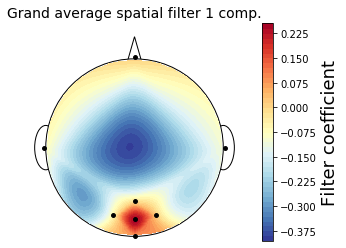

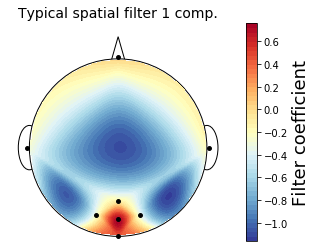

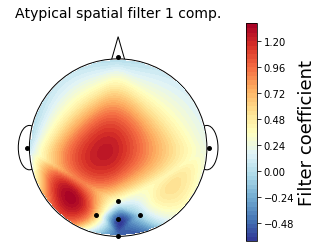

In [78]:
filters_subs = np.mean(filters_1,axis=1) 
grand_av_filters = np.mean(filters_subs,axis=0) 
print(filters_subs.shape)
print(grand_av_filters.shape)

rho = np.corrcoef(grand_av_filters,filters_subs)[0, 1:]
maxmin=np.argmin(rho)
print(maxmin)

topoplot(grand_av_filters,cbar=True)
plt.title('Grand average spatial filter 1 comp.',fontsize=14)
plt.savefig('av filters.pdf', format='pdf')
topoplot(filters_subs[27,:],cbar=True)
plt.title('Typical spatial filter 1 comp.',fontsize=14)
plt.savefig('typ.pdf', format='pdf')
topoplot(filters_subs[29,:],cbar=True)
plt.title('Atypical spatial filter 1 comp.',fontsize=14)
plt.savefig('atyp.pdf', format='pdf')




## Saving and showing results
Here you can save your results and show the average over folds and the grand average over the population

In [31]:
print(np.mean(accuracy_matrix_lda_cca, axis=1))
print(np.mean(np.mean(accuracy_matrix_lda_cca, axis=1)))

[0.94 0.93 0.99 0.91 0.95 0.93 0.99 0.98 0.95 0.91 0.79 0.45 0.94 0.87
 0.97 0.97 0.97 0.93 0.85 0.97 0.87 0.96 0.97 0.87 0.95 0.92 0.96 0.95
 0.96 0.92]
0.9173333333333334


In [33]:
np.save('Results/Cross validatie LDA CCA 1 components 10 min learning',accuracy_matrix_lda_cca)